# Import Data

First, we are going to import a small subset of the total data for exploratory data analysis. We are only interested in the tweets written in English.

In [1]:
# Import Packages
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read Data + display head
csv_data = pd.read_csv("Data/50k_Russian_Tweets.csv", encoding ="ISO-8859–1")

english_data = csv_data[csv_data['language'] == '1']

english_data.head()

,rowid,external_author_id,author,author_label,content,region,region_label,language,language_label,publish_date,...,followers,updates,post_type,post_type_label,account_type,account_type_label,new_june_2018,retweet,account_category,account_category_label
0,1,9.060000e+17,1,10_GOP,"""We have a sitting Democrat US Senator on tria...",1.0,Unknown,1,English,2017-10-01T19:58:00,...,9636,253.0,NaN,1,Right,0,0,1,RightTroll,NaN
1,2,9.060000e+17,1,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,1.0,Unknown,1,English,2017-10-01T22:43:00,...,9637,254.0,NaN,1,Right,0,0,1,RightTroll,NaN
2,3,9.060000e+17,1,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,1.0,Unknown,1,English,2017-10-01T22:50:00,...,9637,255.0,1.0,RETWEET,1,Right,0,1,1,RightTroll
3,4,9.060000e+17,1,10_GOP,JUST IN: President Trump dedicates Presidents ...,1.0,Unknown,1,English,2017-10-01T23:52:00,...,9642,256.0,NaN,1,Right,0,0,1,RightTroll,NaN
4,5,9.060000e+17,1,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",1.0,Unknown,1,English,2017-10-01T02:13:00,...,9645,246.0,1.0,RETWEET,1,Right,0,1,1,RightTroll


In [3]:
right_troll = english_data[english_data.account_category == "RightTroll"]
left_troll = english_data[english_data.account_category == "LeftTroll"]


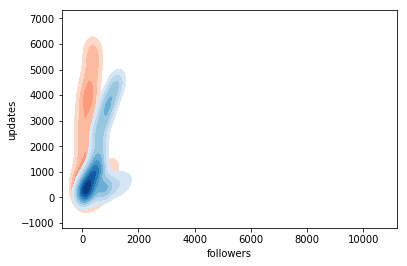

In [4]:
ax = sns.kdeplot(right_troll.followers, right_troll.updates,
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(left_troll.followers, left_troll.updates,
                 cmap="Blues", shade=True, shade_lowest=False)

# Basic Visualizations

Not all of the tweets in this dataset are in English. For the purposes of this project, we are only interested in the English tweets.

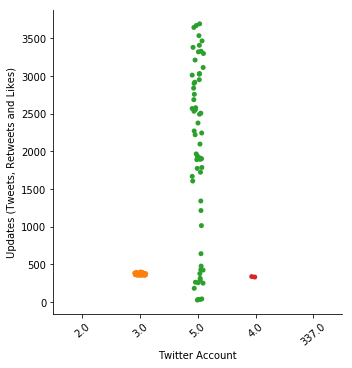

In [5]:
g = sns.catplot(data=english_data, x='author', y='updates', order = english_data['updates'].value_counts().iloc[:5].index)
g.set_axis_labels("Twitter Account", "Updates (Tweets, Retweets and Likes)")
g.set_xticklabels(rotation=40)
g

In [6]:
data = []

data['max_updates'] = english_data.groupby(["author_label", "updates"]).max()
#data['max_retweets'] = english_data.groupby("author_label")["followers"].max()

print(data)

TypeError: list indices must be integers or slices, not str

# Network Analysis

We are interested in the structure of the social network within which these accounts reside. 

Degree, centrality, pagerank?

# Key Influencers 

We can see that there are a few accounts which stand out as being influential. What are their common characteristics?

# Sentiment Analysis

Previous studies have show that influential Twitter accounts tend to have a distinct sentiment 